<a href="https://colab.research.google.com/github/harshinii-24/CodeClauseInternship_Demand-Forecasting-for-a-Retail-Store/blob/main/Demand_Forecasting_for_a_Retail_Store.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import pandas as pd
import numpy as np
from random import gauss, shuffle

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import het_arch, acorr_ljungbox

In [ ]:
from sklearn.metrics import mean_absolute_percentage_error as mape, mean_squared_error as mse
from scipy.stats import shapiro, probplot
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.multioutput import MultiOutputRegressor
from sklearn.cluster import KMeans


In [ ]:
import os
import lightgbm as lgb

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [ ]:
from  datetime import datetime, timedelta
import gc, copy

In [ ]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

In [ ]:
from gensim.models import Word2Vec

In [ ]:
import warnings
warnings.simplefilter(action='ignore', category= FutureWarning)

In [ ]:
class CFG:
    data_folder = '../input/tsdata-1/'
    img_dim1 = 20
    img_dim2 = 10

In [ ]:
plt.rcParams.update({'figure.figsize': (CFG.img_dim1,CFG.img_dim2)})

In [ ]:
def my_rmse(x,y):
    return(np.round( np.sqrt(mse(x,y)) ,4))

In [ ]:
xdat = pd.read_csv('sales_train_validation.csv')
xdat = xdat.loc[xdat.state_id == 'CA']
xdat.head(5)

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.0,3.0,0.0,1.0,1.0,1.0,3.0,0.0,1.0,1.0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2.0,1.0,2.0,1.0,1.0,1.0,0.0,1.0,1.0,1.0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1.0,0.0,5.0,4.0,1.0,0.0,1.0,3.0,7.0,2.0
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2.0,1.0,1.0,0.0,1.0,1.0,2.0,2.0,2.0,4.0


In [ ]:
def reduce_mem_usage(df):
    """ iterate all the columns of a dataframe and modify the data type
        to reduce memory usage.
    """
    start_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        else:
            df[col] = df[col].astype('category')

    end_mem = df.memory_usage().sum() / 1024**2
    print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


xdat = reduce_mem_usage(xdat)

Memory usage of dataframe is 178.65 MB
Memory usage after optimization is: 42.86 MB
Decreased by 76.0%


In [ ]:
xdat = pd.melt(xdat, id_vars=['id', 'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id'], var_name='d', value_name='sales').dropna()

In [ ]:
xcal = pd.read_csv('calendar.csv')

In [ ]:
xdat = pd.merge(xdat, xcal, on='d', how='left')
del xcal

In [ ]:
xdat.drop(['d', 'wm_yr_wk', 'weekday', 'month', 'year',  'event_name_1', 'event_type_1','event_name_2', 'event_type_2', 'snap_TX', 'snap_WI', 'state_id'],axis = 1, inplace = True)
xdat.head(3)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0.0,2011-01-29,1,0


<Axes: xlabel='date'>

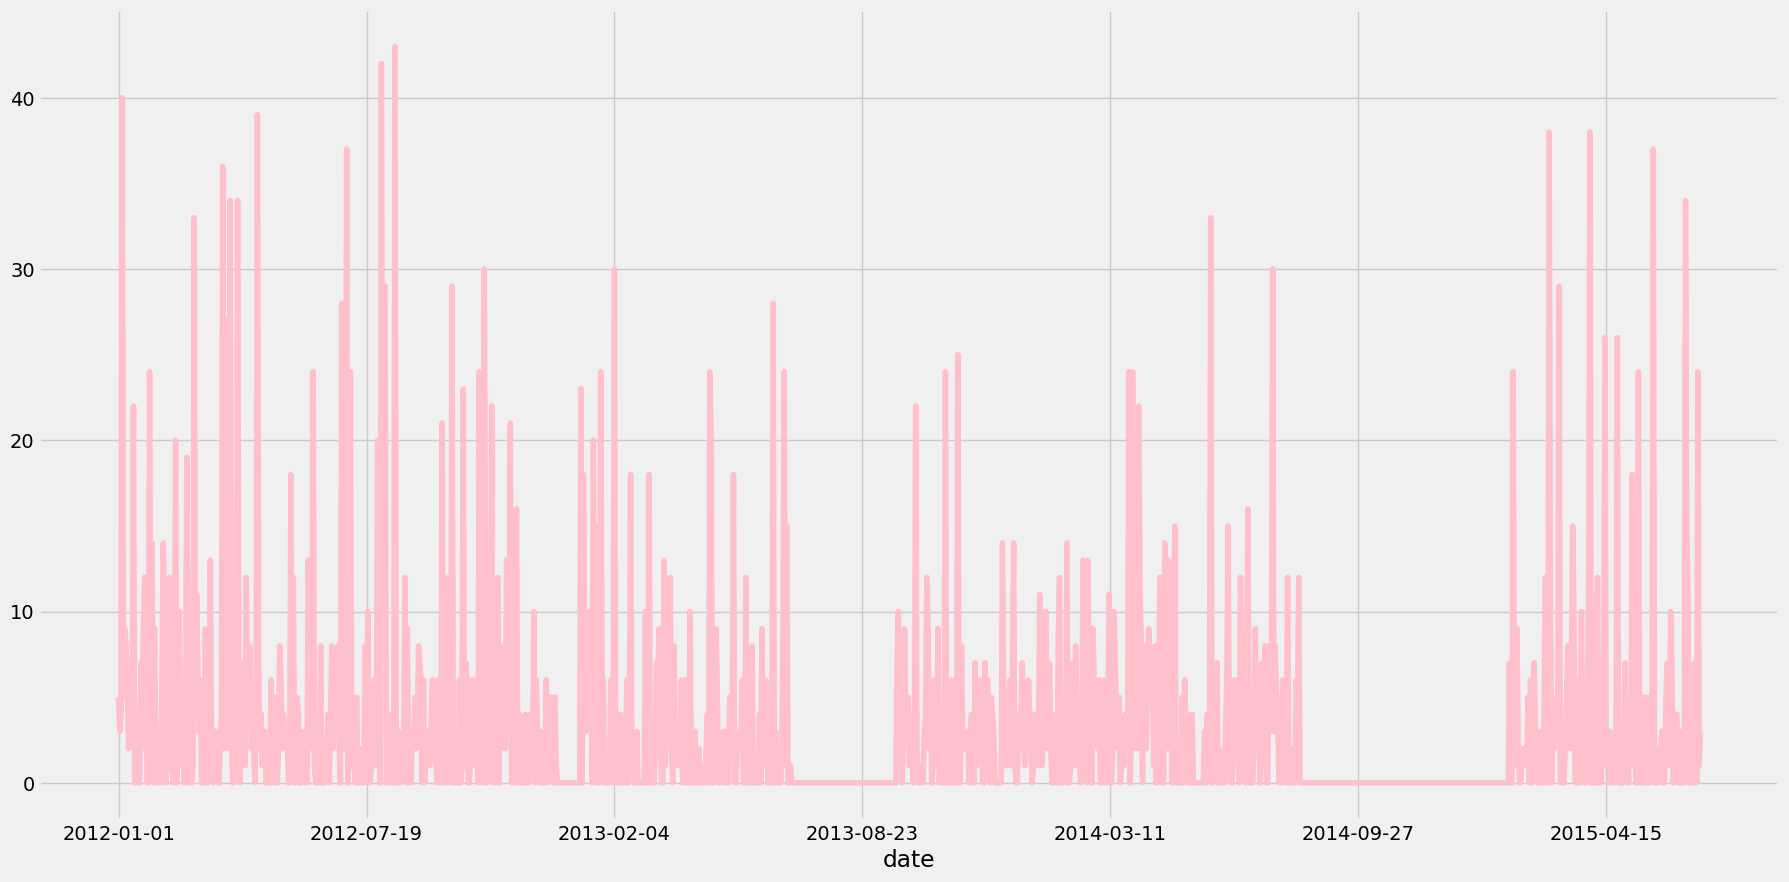

In [ ]:
df = xdat.loc[(xdat.item_id == 'HOBBIES_1_288') & (xdat.store_id == 'CA_1') ][['date', 'sales']].copy()
df = df.loc[(df.date >= '2012-01-01') & (df.date <= '2015-06-30')]
df.set_index('date').sales.plot(color='pink')

In [ ]:
def Croston(ts,extra_periods=1,alpha=0.4):

    d = np.array(ts)
    cols = len(d)
    d = np.append(d,[np.nan]*extra_periods)

    #level (a), periodicity(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    q = 1 #periods since last demand observation

    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1 + first_occurence
    f[0] = a[0]/p[0]
    # Create all the t+1 forecasts
    for t in range(0,cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = alpha*q + (1-alpha)*p[t]
            f[t+1] = a[t+1]/p[t+1]
            q = 1
        else:
            a[t+1] = a[t]
            p[t+1] = p[t]
            f[t+1] = f[t]
            q += 1

    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
pred_croston =  Croston(df.sales, extra_periods = 10)
pred_croston

,Demand,Forecast,Period,Level,Error
0,5.0,5.000000,1.000000,5.000000,0.000
1,3.0,5.000000,1.000000,5.000000,-2.000
2,4.0,4.200000,1.000000,4.200000,-0.200
3,40.0,4.120000,1.000000,4.120000,35.880
4,5.0,18.472000,1.000000,18.472000,-13.472
...,...,...,...,...,...
1282,NaN,5.050468,1.299267,6.561904,NaN
1283,NaN,5.050468,1.299267,6.561904,NaN
1284,NaN,5.050468,1.299267,6.561904,NaN
1285,NaN,5.050468,1.299267,6.561904,NaN


In [ ]:
pred_croston = pred_croston.Forecast.head(len(df))

print('RMSE: ' + str(my_rmse(df.sales,pred_croston)))

RMSE: 6.9581


<Axes: xlabel='date'>

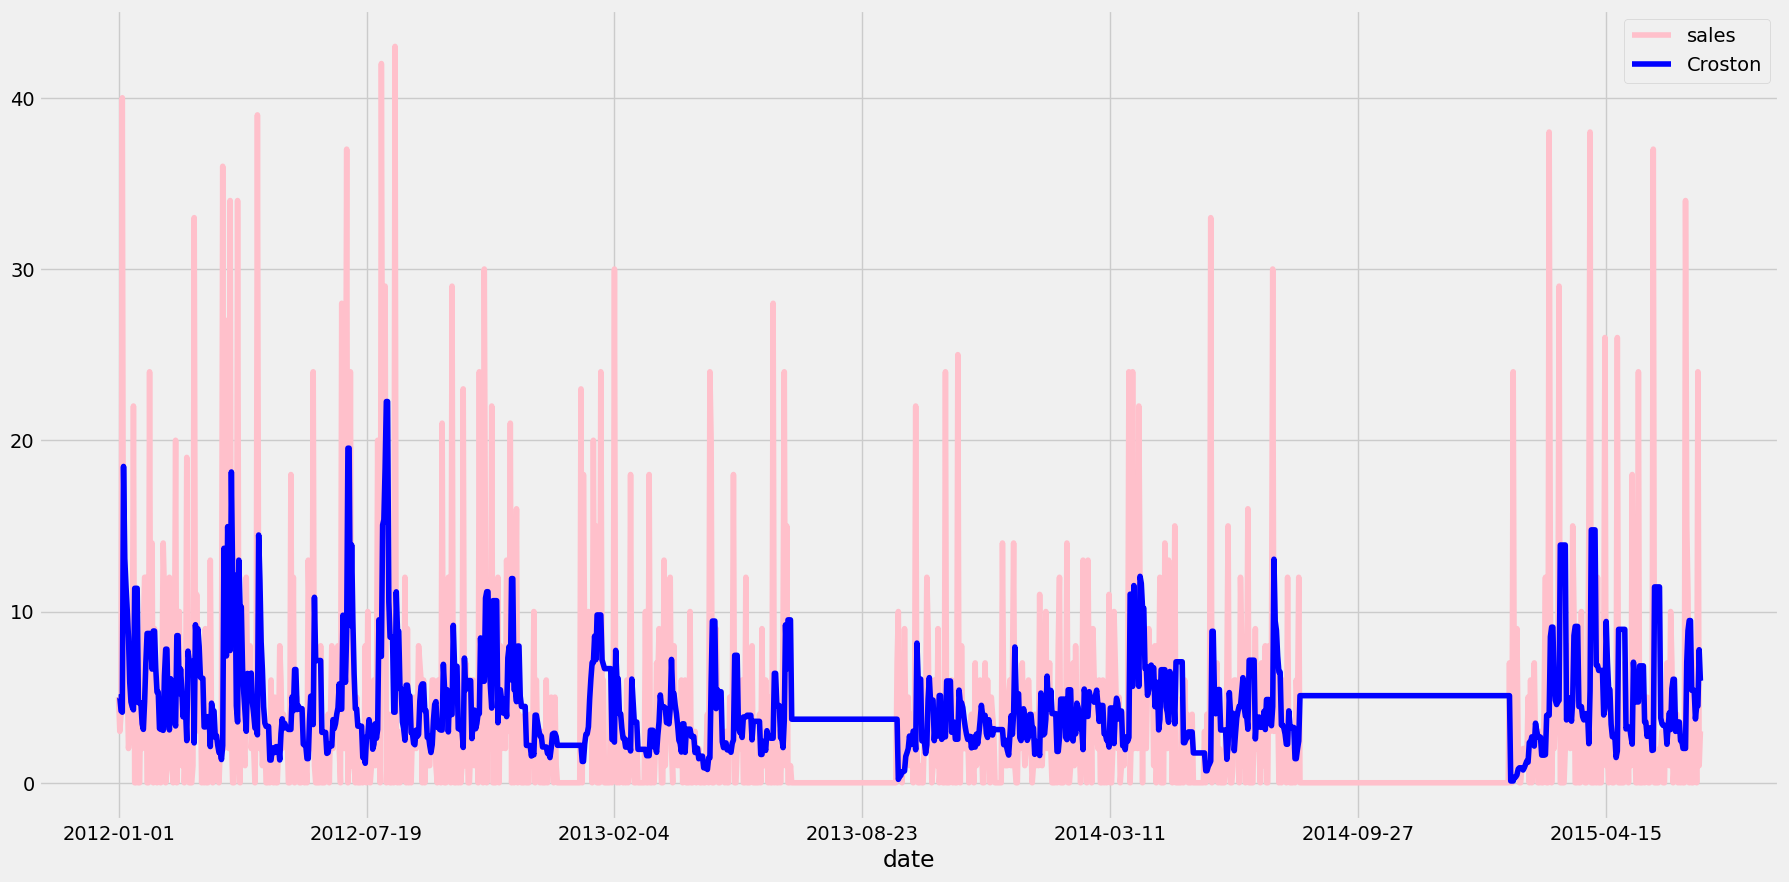

In [ ]:
df['Croston'] = pred_croston.values
df.set_index('date')[['sales', 'Croston']].plot(color=['pink', 'blue'])

In [ ]:
def Croston_TSB(ts,extra_periods=1,alpha=0.4,beta=0.1):
    d = np.array(ts) # Transform the input into a numpy array
    cols = len(d) # Historical period length
    d = np.append(d,[np.nan]*extra_periods) # Append np.nan into the demand array to cover future periods

    #level (a), probability(p) and forecast (f)
    a,p,f = np.full((3,cols+extra_periods),np.nan)
    # Initialization
    first_occurence = np.argmax(d[:cols]>0)
    a[0] = d[first_occurence]
    p[0] = 1/(1 + first_occurence)
    f[0] = p[0]*a[0]

    # Create all the t+1 forecasts
    for t in range(0,cols):
        if d[t] > 0:
            a[t+1] = alpha*d[t] + (1-alpha)*a[t]
            p[t+1] = beta*(1) + (1-beta)*p[t]
        else:
            a[t+1] = a[t]
            p[t+1] = (1-beta)*p[t]
        f[t+1] = p[t+1]*a[t+1]

    # Future Forecast
    a[cols+1:cols+extra_periods] = a[cols]
    p[cols+1:cols+extra_periods] = p[cols]
    f[cols+1:cols+extra_periods] = f[cols]

    df = pd.DataFrame.from_dict({"Demand":d,"Forecast":f,"Period":p,"Level":a,"Error":d-f})
    return df

In [ ]:
pred_croston_tsb =  Croston_TSB(df.sales, extra_periods = 10, alpha = 0.1, beta = 0.1)
pred_croston_tsb = pred_croston_tsb.Forecast.head(len(df))
print('RMSE: ' + str(my_rmse(df.sales,pred_croston_tsb)))

RMSE: 6.1255


<Axes: xlabel='date'>

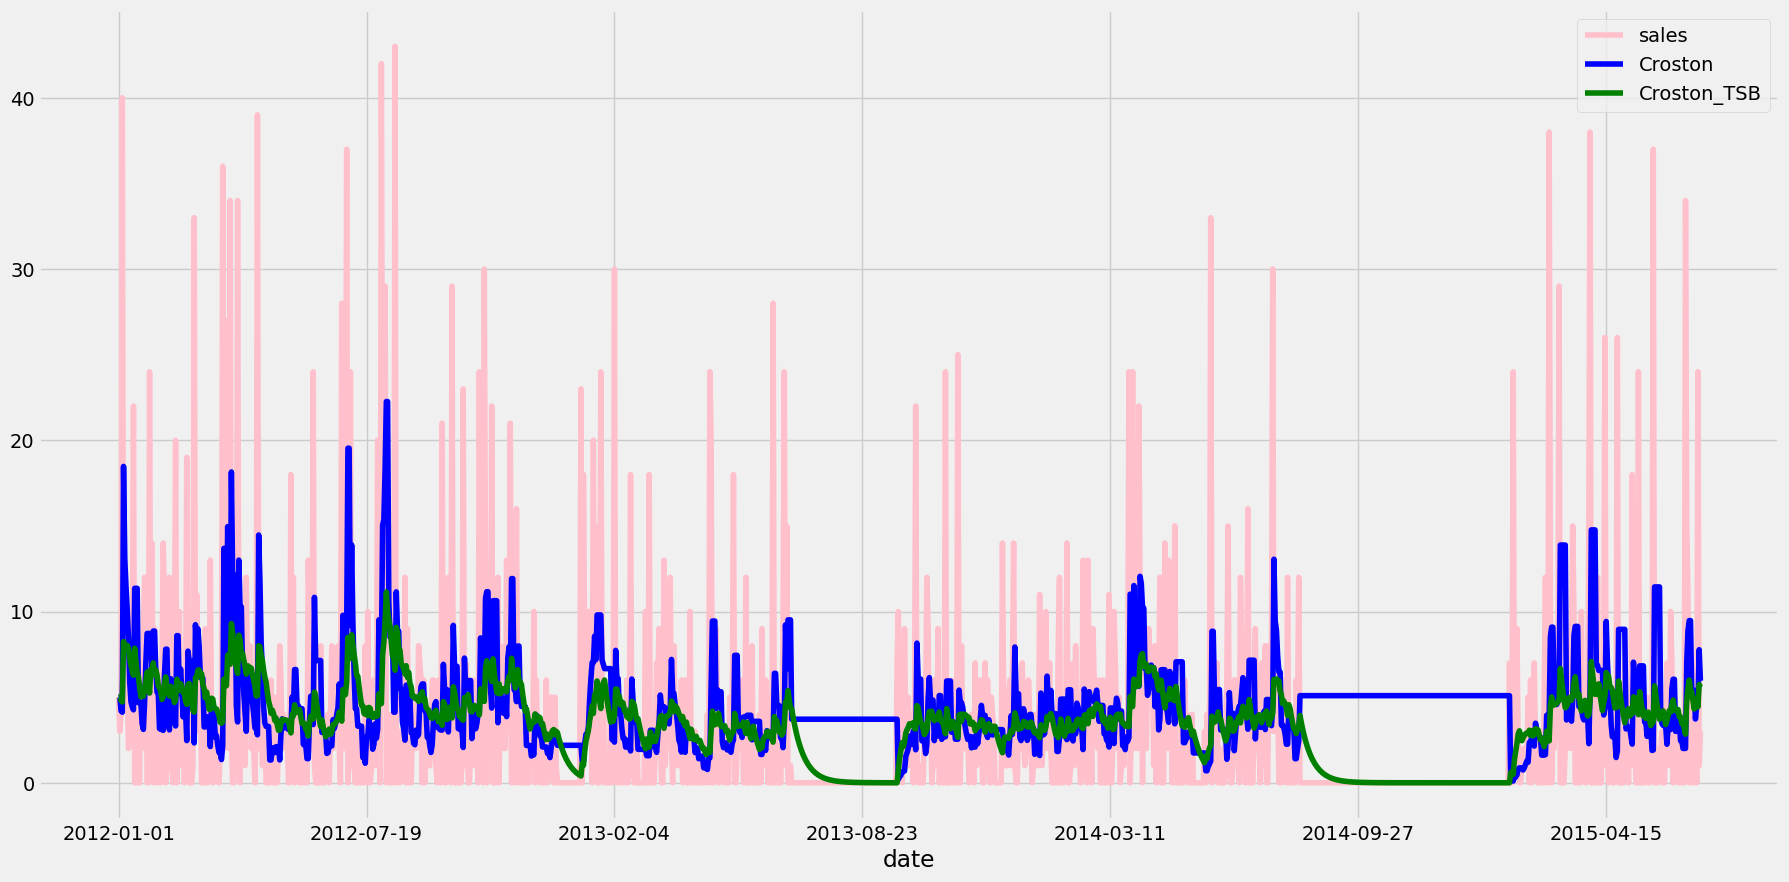

In [ ]:
df['Croston_TSB'] = pred_croston_tsb.values
df.set_index('date')[['sales', 'Croston', 'Croston_TSB']].plot(color=['pink', 'blue', 'green'])

In [ ]:
xdat.head(4)

,id,item_id,dept_id,cat_id,store_id,sales,date,wday,snap_CA
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,0,2011-01-29,1,0


<Axes: xlabel='date'>

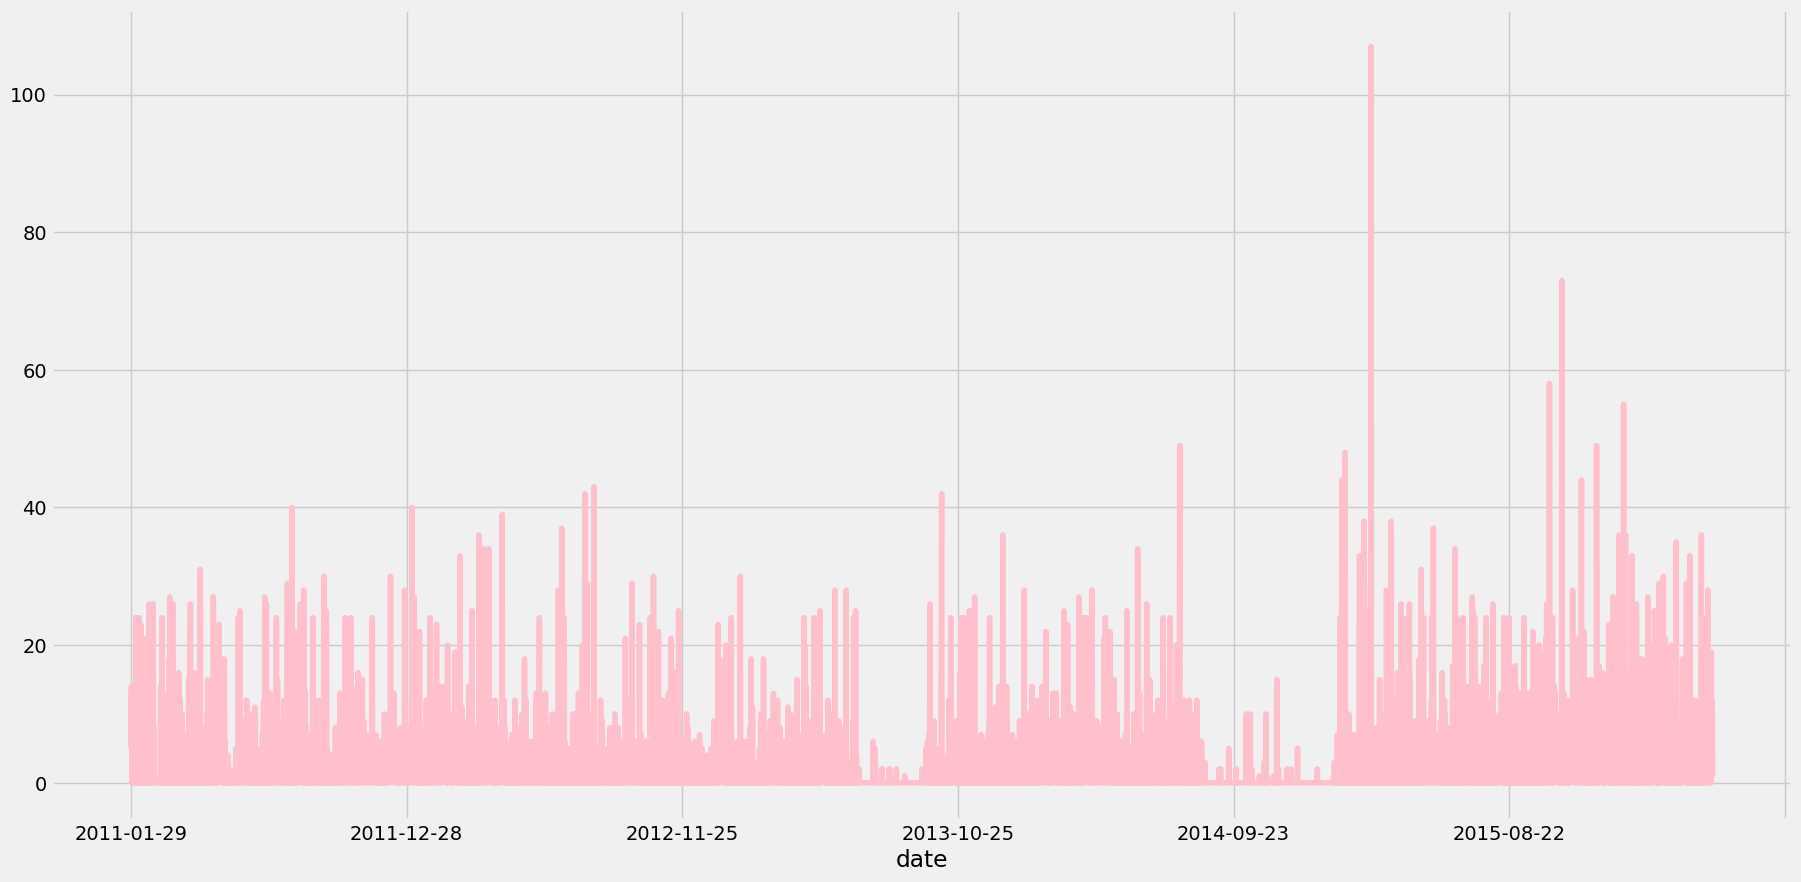

In [ ]:
df = xdat.loc[xdat.item_id == 'HOBBIES_1_288' ][['date', 'sales']].copy()
df.set_index('date').sales.plot(color='pink')

<Axes: xlabel='date'>

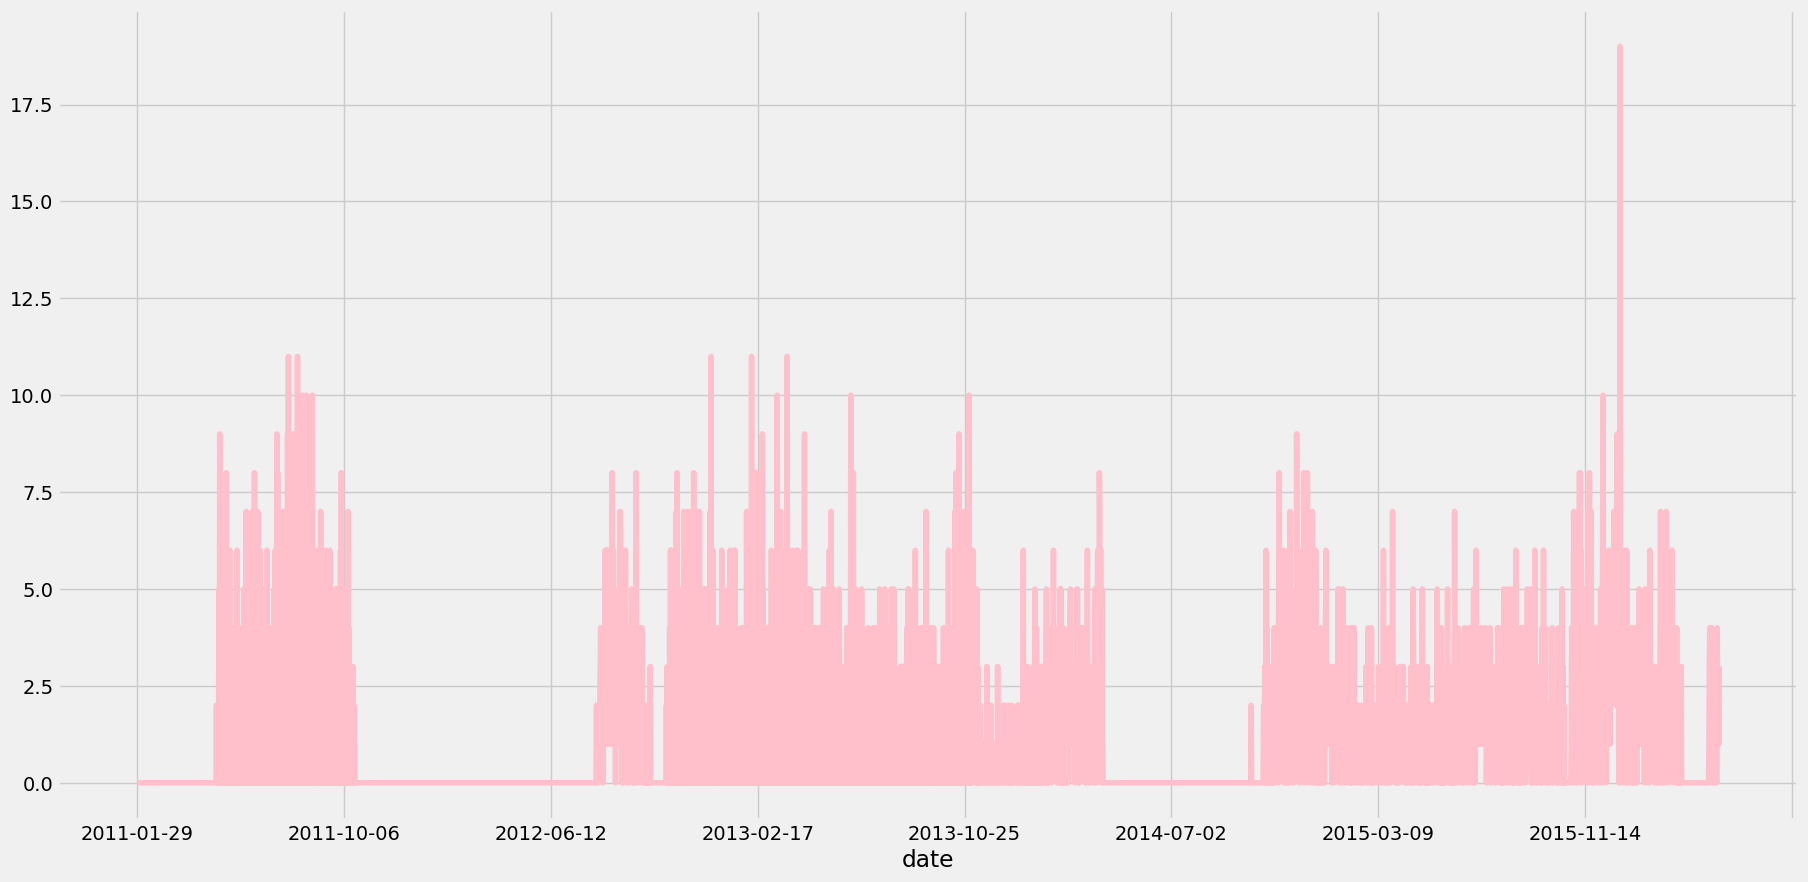

In [ ]:
df = xdat.loc[xdat.item_id == 'FOODS_3_823' ][['date', 'sales']].copy()
df.set_index('date').sales.plot(color='pink')

<Axes: xlabel='date'>

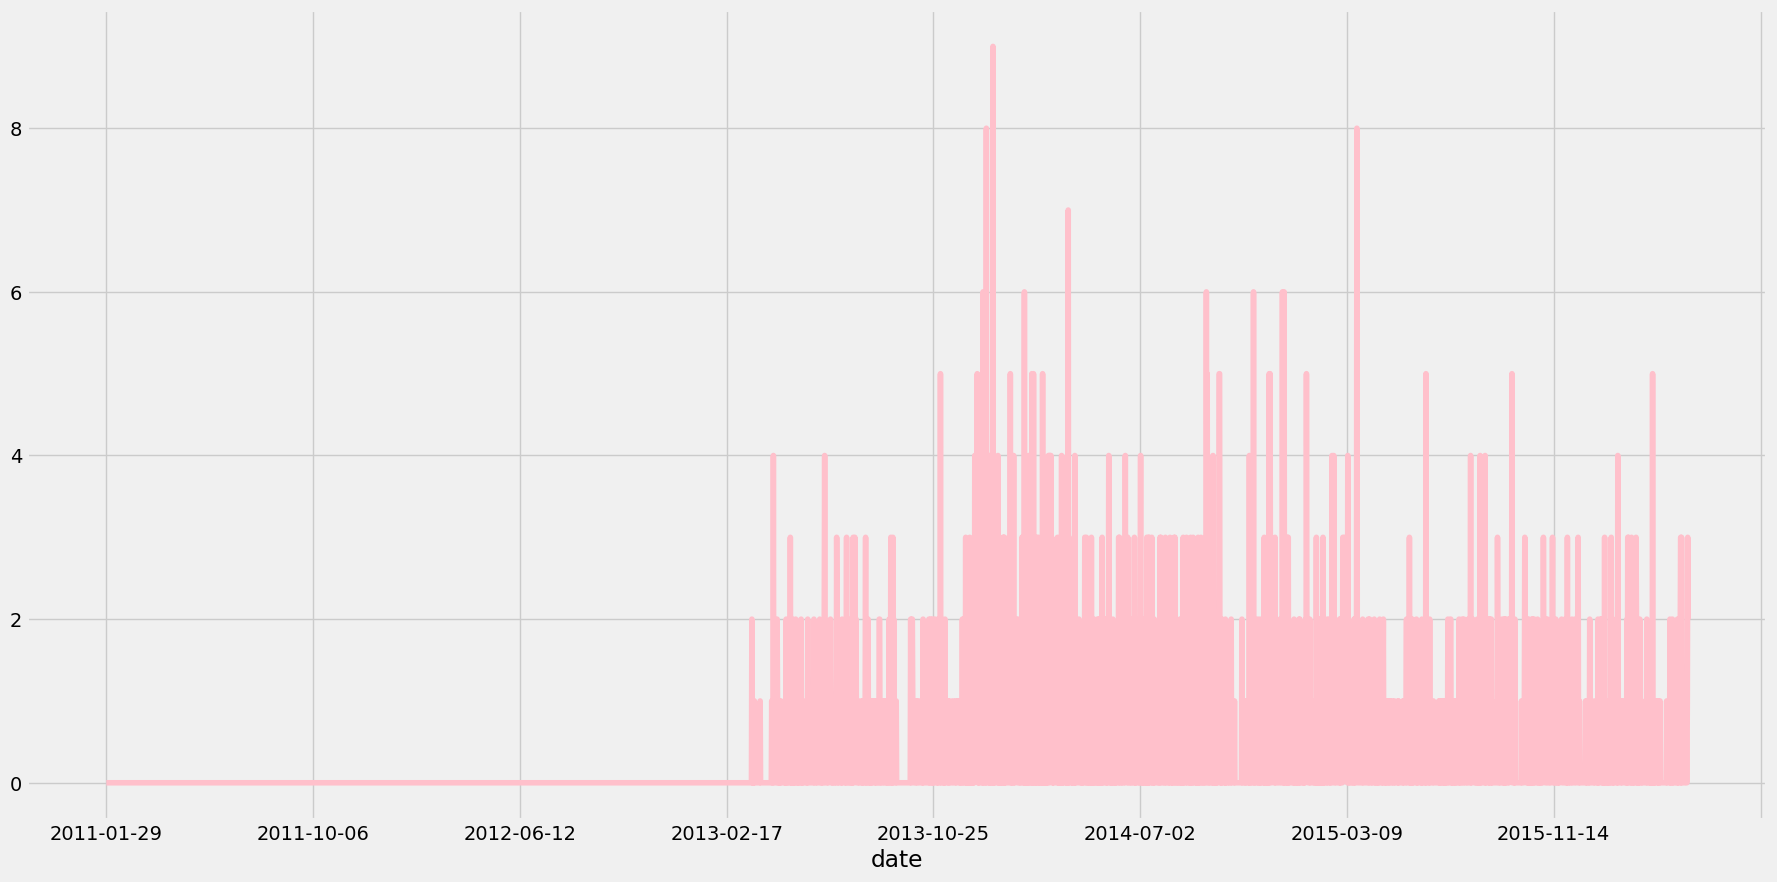

In [ ]:
df = xdat.loc[xdat.item_id == 'HOUSEHOLD_2_513' ][['date', 'sales']].copy()
df.set_index('date').sales.plot(color='pink')